In [1]:
from multiprocessing import Pool
import numpy as np
import scipy
from matplotlib import pyplot as plt
%matplotlib inline
import lal
import lalsimulation as lalsim
from bilby.gw.detector import PowerSpectralDensity
from bilby.gw.utils import noise_weighted_inner_product
import bilby


luminosity_distance = 800.0 * 1e6 * lal.PC_SI   # fix luminosity distance to 800 Mpc
inclination = np.pi / 2  # edge-on, only considering plus polarization
reference_phase = 0.0
reference_frequency = 20

sampling_frequency = 4096
delta_t = 1 / sampling_frequency

longitude_ascending_nodes = 0.0
eccentricity = 0.0
mean_per_ano = 0.0

minimum_frequency = 20.0
maximum_frequency = 2048.0


def fd_waveform_NRHybSur3dq8(mass_1, mass_2, chi_1, chi_2):
    """
    Computing waveform of NRHybSur3dq8 and transforming to FD.

    Considering the low frequency cut of 20Hz, and using a tapering with 0.2 inspiral chirp
    time. to guarante the tapering is end before 20Hz, considering 18Hz here.

    Return: TD waveform (lal TimeSeries), tapered TD wavefrom (np array), window (np array), 
    FD wavefrom (np array), freq (np array)
    """
    # determining the start frequency
    redundancy = 0.2
    duration = lalsim.SimInspiralChirpTimeBound(
        18, mass_1 * lal.MSUN_SI, mass_2 * lal.MSUN_SI, chi_1, chi_2
    )
    duration *= 1 + redundancy
    fstart = lalsim.SimInspiralChirpStartFrequencyBound(
        duration,
        mass_1 * lal.MSUN_SI,
        mass_2 * lal.MSUN_SI,
    )
    # Computing TD waveform
    appro_NRHybSur3dq8 = lalsim.GetApproximantFromString("NRHybSur3dq8")
    extraParams = lal.CreateDict()
    plus_nrhyb, _ = lalsim.SimInspiralChooseTDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(luminosity_distance),
        float(inclination),
        float(reference_phase),
        float(longitude_ascending_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_t),
        float(fstart),
        float(reference_frequency),
        extraParams,
        appro_NRHybSur3dq8,
    )
    # Tapering the TD waveform
    full_length = plus_nrhyb.data.length
    t0 = float(plus_nrhyb.epoch)
    taper_width = int(np.floor(-t0 / delta_t / (1 + redundancy) * redundancy))
    one_width = full_length - taper_width
    window = np.hanning(int(taper_width * 2))
    window = np.append(window[0:taper_width], np.ones(one_width))
    plus_nrhyb_tapered = plus_nrhyb.data.data * window
    # Fourier transform
    freq = np.fft.rfftfreq(full_length, 1 / sampling_frequency)
    time_shift = -1j * 2 * np.pi * freq * t0
    plus_nrhyb_fd = (
        np.fft.rfft(plus_nrhyb_tapered) / sampling_frequency * np.exp(time_shift)
    )

    return plus_nrhyb, plus_nrhyb_tapered, window, plus_nrhyb_fd, freq


def fd_waveform_IMRPhenomXAS(f_array, mass_1, mass_2, chi_1, chi_2):
    # DEFINE_INSERT_FUNC(PhenomXInspiralPhaseVersion, INT4, "InsPhaseVersion", 104)
    # DEFINE_INSERT_FUNC(PhenomXInspiralAmpVersion, INT4, "InsAmpVersion", 103)
    # DEFINE_INSERT_FUNC(PhenomXIntermediatePhaseVersion, INT4, "IntPhaseVersion", 105)
    # DEFINE_INSERT_FUNC(PhenomXIntermediateAmpVersion, INT4, "IntAmpVersion", 104)
    # DEFINE_INSERT_FUNC(PhenomXRingdownPhaseVersion, INT4, "RDPhaseVersion", 105)
    # DEFINE_INSERT_FUNC(PhenomXRingdownAmpVersion, INT4, "RDAmpVersion", 103)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXInspiralPhaseVersion(104)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXInspiralAmpVersion(103)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXIntermediatePhaseVersion(105)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXIntermediateAmpVersion(104)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXRingdownPhaseVersion(105)
    # lalsim.SimInspiralWaveformParamsInsertPhenomXRingdownAmpVersion(103)
    extraParams = lal.CreateDict()  # using the default fitting model of IMRPhenomXAS
    appro_PhenomXAS = lalsim.GetApproximantFromString("IMRPhenomXAS")

    f_array_lal = lal.CreateREAL8Vector(len(f_array))
    f_array_lal.data = f_array

    plus_xas, _ = lalsim.SimInspiralChooseFDWaveformSequence(
        float(reference_phase),
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(reference_frequency),
        float(luminosity_distance),
        float(inclination),
        extraParams,
        appro_PhenomXAS,
        f_array_lal,
    )
    return plus_xas.data.data


def fd_waveform_approx(approx_lal, extra_params_lal, f_array, mass_1, mass_2, chi_1, chi_2):
    f_array_lal = lal.CreateREAL8Vector(len(f_array))
    f_array_lal.data = f_array

    plus, _ = lalsim.SimInspiralChooseFDWaveformSequence(
        float(reference_phase),
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(reference_frequency),
        float(luminosity_distance),
        float(inclination),
        extra_params_lal,
        approx_lal,
        f_array_lal,
    )
    return plus.data.data


def normalising(hf, psd_array, delta_f):
    return hf / np.sqrt(
        noise_weighted_inner_product(hf, hf, psd_array, 1 / delta_f).real
    )

def mismatch(h1, h2, psd_array, delta_f):
    # Normalizing the waveform
    norm_factor_1 = np.sqrt(
        noise_weighted_inner_product(h1, h1, psd_array, 1 / delta_f).real
    )
    norm_factor_2 = np.sqrt(
        noise_weighted_inner_product(h2, h2, psd_array, 1 / delta_f).real
    )
    return 1 - noise_weighted_inner_product(h1, h2, psd_array, 1 / delta_f).real / (
        norm_factor_1 * norm_factor_2
    )


def _mismatch_with_time_phase_shift(time_phase_shift, freq, delta_f, psd_array, h1, h2):
    shift = 1j * (2 * np.pi * freq * time_phase_shift[0] + time_phase_shift[1])
    h1_shifted = h1 * np.exp(shift)
    return mismatch(h1_shifted, h2, psd_array, delta_f)



/tmp/ipykernel_1433164/1297106706.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/hydrogen/miniconda3/envs/igwn/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# num = 1
# parameters = {}
# rng = np.random.default_rng(seed=20241015)
# parameters["total_mass"] = rng.uniform(20, 250, num)
# parameters["mass_ratio"] = rng.uniform(0.125, 1.0, num)
# parameters["chi_1"] = rng.uniform(-0.8, 0.8, num)
# parameters["chi_2"] = rng.uniform(-0.8, 0.8, num)
# parameters["mismatch"] = np.zeros(num)
# parameters = bilby.gw.conversion.generate_mass_parameters(parameters)
# # parameters = pd.DataFrame(parameters)
# print(parameters)
parameters = {
    "total_mass": 43.95150288,
    "mass_ratio": 0.6560166,
    "chi_1": -0.31793288,
    "chi_2": -0.23096549,
}
parameters = bilby.gw.conversion.generate_mass_parameters(parameters)
print(parameters)

{'total_mass': 43.95150288, 'mass_ratio': 0.6560166, 'chi_1': -0.31793288, 'chi_2': -0.23096549, 'mass_1': 26.54049656265523, 'mass_2': 17.411006317344768, 'chirp_mass': 18.631379170068303, 'symmetric_mass_ratio': 0.2392133743546127}


## Waveform of NRHybSur3dq8

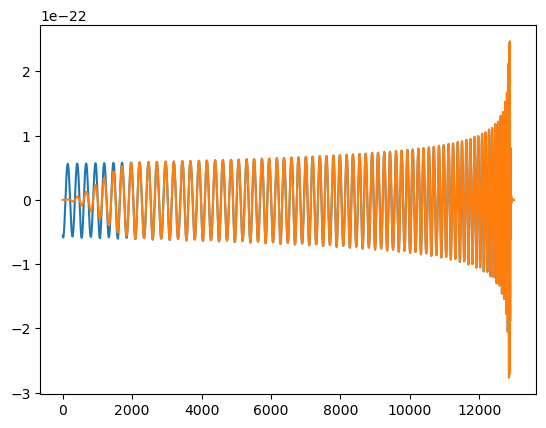

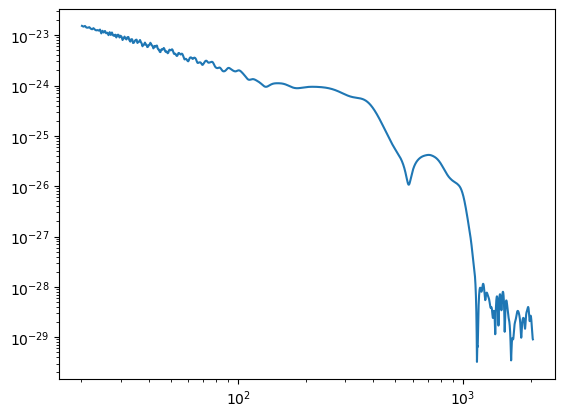

In [3]:
td_plus, td_plus_tapered, window, fd_plus, freq = fd_waveform_NRHybSur3dq8(
    parameters["mass_1"], parameters["mass_2"], parameters["chi_1"], parameters["chi_2"]
)
freq_mask = (freq >= minimum_frequency) * (freq <= maximum_frequency)

fig, ax = plt.subplots()
ax.plot(td_plus.data.data)
ax.plot(td_plus_tapered)
fig.show()

fig, ax = plt.subplots()
ax.loglog(freq[freq_mask], np.abs(fd_plus)[freq_mask])
fig.show()

## Waveform of IMRPhenomXAS

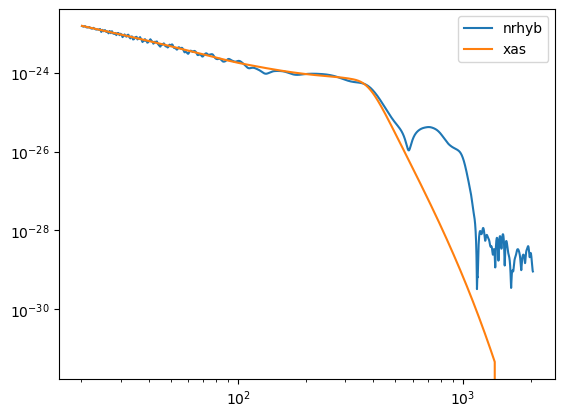

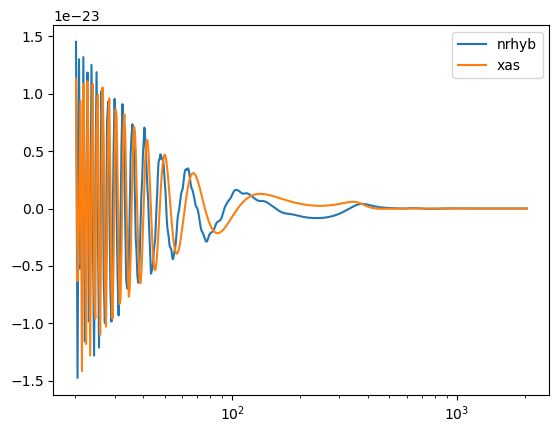

In [4]:
plus_xas = fd_waveform_IMRPhenomXAS(
    freq[freq_mask],
    parameters["mass_1"],
    parameters["mass_2"],
    parameters["chi_1"],
    parameters["chi_2"],
)

fig, ax = plt.subplots()
ax.loglog(freq[freq_mask], np.abs(fd_plus)[freq_mask], label="nrhyb")
ax.loglog(freq[freq_mask], np.abs(plus_xas), label="xas")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.semilogx(freq[freq_mask], fd_plus[freq_mask].real, label="nrhyb")
ax.semilogx(freq[freq_mask], plus_xas.real, label="xas")
ax.legend()
fig.show()

## Power spectral density of Aplus design

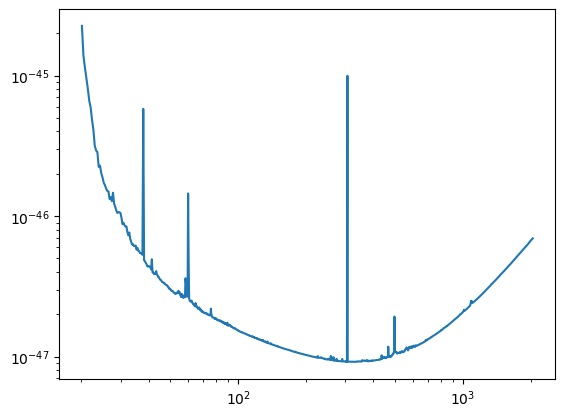

In [5]:
# PSD_Aplus = PowerSpectralDensity(asd_file="AplusDesign.txt")
PSD_Aplus = PowerSpectralDensity(asd_file="aligo_O4high.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freq[freq_mask])

fig, ax = plt.subplots()
ax.loglog(freq[freq_mask], psd_array)
fig.show()

## Time and phase shift

In [6]:
delta_f = freq[1] - freq[0]
scipy.optimize.dual_annealing(
    _mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(freq[freq_mask], delta_f, psd_array, fd_plus[freq_mask], plus_xas),
)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 0.01071167161156894
       x: [-8.696e-05 -1.094e+00]
     nit: 1000
    nfev: 4112
    njev: 37
    nhev: 0

In [7]:
scipy.optimize.direct(
    _mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(freq[freq_mask], delta_f, psd_array, fd_plus[freq_mask], plus_xas),
)

 message: Number of function evaluations done is larger than maxfun=2000
 success: False
  status: 1
     fun: 0.01071192883268346
       x: [-8.806e-05 -1.093e+00]
     nit: 102
    nfev: 2019

In [8]:
scipy.optimize.differential_evolution(
    _mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(freq[freq_mask], delta_f, psd_array, fd_plus[freq_mask], plus_xas),
)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.010711671616743357
                   x: [-8.696e-05 -1.094e+00]
                 nit: 23
                nfev: 783
          population: [[-8.472e-05 -1.097e+00]
                       [-8.185e-05 -1.100e+00]
                       ...
                       [-7.386e-05 -1.111e+00]
                       [-8.332e-05 -1.106e+00]]
 population_energies: [ 1.071e-02  1.072e-02 ...  1.078e-02  1.077e-02]
                 jac: [-4.513e-04 -2.220e-08]

In [9]:
scipy.optimize.shgo(
    _mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(freq[freq_mask], delta_f, psd_array, fd_plus[freq_mask], plus_xas),
)

 message: Optimization terminated successfully.
 success: True
     fun: 0.010711671638063192
    funl: [ 1.071e-02]
       x: [-8.697e-05 -1.094e+00]
      xl: [[-8.697e-05 -1.094e+00]]
     nit: 1
    nfev: 37
   nlfev: 32
   nljev: 8
   nlhev: 0

In [10]:
# scipy.optimize.brute(
#     _mismatch_with_time_phase_shift,
#     ranges=((-0.1, 0.1), (-np.pi, np.pi)),
#     args=(freq[freq_mask], delta_f, psd_array, fd_plus[freq_mask], plus_xas),
#     Ns=1000,
# )

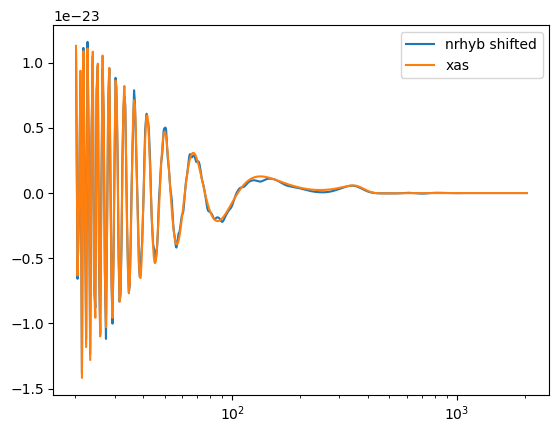

In [11]:
t_shift = -8.826e-05
phi_shift = -1.092

fig, ax = plt.subplots()
ax.semilogx(
    freq[freq_mask],
    (
        fd_plus[freq_mask]
        * np.exp(1j * (2 * np.pi * freq[freq_mask] * t_shift + phi_shift))
    ).real,
    label="nrhyb shifted",
)
ax.semilogx(freq[freq_mask], plus_xas.real, label="xas")
ax.legend()
fig.show()

## Mismatch in the parameter space

In [12]:
num = 1000
parameters = {}
rng = np.random.default_rng()
parameters["total_mass"] = rng.uniform(20, 250, num)
parameters["mass_ratio"] = rng.uniform(0.125, 1.0, num)
parameters["chi_1"] = rng.uniform(-0.8, 0.8, num)
parameters["chi_2"] = rng.uniform(-0.8, 0.8, num)
parameters = bilby.gw.conversion.generate_mass_parameters(parameters)
params_array = np.vstack(
    [
        parameters["mass_1"],
        parameters["mass_2"],
        parameters["chi_1"],
        parameters["chi_2"],
    ]
).T


def _minimized_mismatch(mass_1, mass_2, chi_1, chi_2):
    _, _, _, hf_hyb, freq = fd_waveform_NRHybSur3dq8(mass_1, mass_2, chi_1, chi_2)
    freq_mask = (freq >= minimum_frequency) * (freq <= maximum_frequency)
    freq = freq[freq_mask]
    hf_hyb = hf_hyb[freq_mask]
    delta_f = freq[1] - freq[0]

    hf_xas = fd_waveform_IMRPhenomXAS(freq, mass_1, mass_2, chi_1, chi_2)

    psd_array = PSD_Aplus.get_power_spectral_density_array(freq)

    minimizing_res = scipy.optimize.dual_annealing(
        _mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(freq, delta_f, psd_array, hf_hyb, hf_xas),
    )
    if minimizing_res.success:
        return minimizing_res.fun
    else:
        raise ValueError("minimizing func exited fail")

In [13]:
from multiprocessing import Pool

nproc = 72

with Pool(processes=nproc) as pool:
    mism = np.array(pool.starmap(_minimized_mismatch, params_array))
parameters["mismatch"] = mism

print(parameters)

{'total_mass': array([168.04610843,  91.95619094, 188.6221055 ,  24.27839885,
       192.48775514, 249.98228619, 205.78982711,  29.11158424,
       102.62270476,  38.86825463,  77.3556134 , 238.61323666,
       223.37252163,  31.70307647, 156.20493992,  35.66889654,
       109.87469305,  27.17272613,  40.75213717,  25.22908275,
       176.9312929 ,  38.97023297,  52.4493925 ,  27.59912898,
       190.811042  , 220.75864704, 197.50407433,  99.14773134,
        95.335524  ,  23.22894239,  50.52681129,  40.77040634,
        27.3705035 , 201.11009835, 196.98841494, 110.96674701,
       215.64257625, 247.46629213, 243.13099624, 111.7601093 ,
       158.23873468,  97.60522195,  87.24554923,  52.12611687,
       140.38636428, 163.86926132, 201.83078424, 179.07137348,
       235.33850825, 151.89478724,  39.04481685,  47.29617316,
        55.48193946, 176.19740471, 203.3711215 , 234.11705193,
       164.5187397 ,  89.15260491,  69.35262685, 184.07233671,
       133.03548846, 140.57031247,  86.4

[(168.04610843, 0.85431089, -0.75494628,  0.06592466,  90.62455972,  77.42154871,  72.87506692, 0.24845678, 0.02566944)
 ( 91.95619094, 0.68384774,  0.39431323,  0.30288756,  54.61075168,  37.34543926,  39.17357805, 0.24118694, 0.01505283)
 (188.6221055 , 0.65229912, -0.16403074,  0.15285217, 114.15735998,  74.46474551,  79.90137593, 0.23892932, 0.03635532)
 ( 24.27839885, 0.90904338,  0.14626784,  0.38574883,  12.71757318,  11.56082567,  10.55338666, 0.24943249, 0.00201793)
 (192.48775514, 0.37547432, -0.6248306 , -0.64637252, 139.94281996,  52.54493517,  72.94713967, 0.19846104, 0.07837882)
 (249.98228619, 0.38913332, -0.39541786, -0.58179428, 179.95557613,  70.02671005,  95.64792917, 0.20165573, 0.08841323)
 (205.78982711, 0.78227612,  0.49103625,  0.53652797, 115.46461558,  90.32521153,  88.77076455, 0.2462692 , 0.01838681)
 ( 29.11158424, 0.18915121,  0.14913054, -0.1748172 ,  24.48097768,   4.63060655,   8.70696535, 0.13376268, 0.05354478)
 (102.62270476, 0.74856386, -0.04251576,

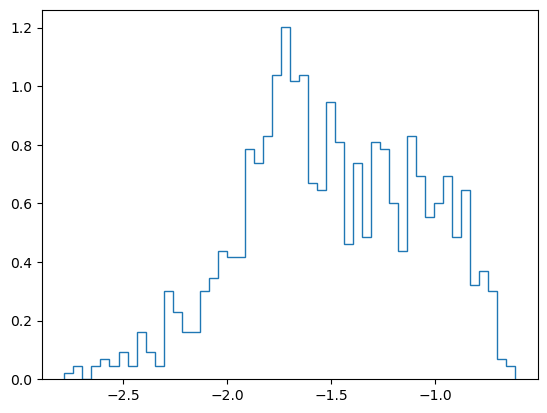

In [14]:
param_keys = list(parameters.keys())
structed_params = np.array(
    list(zip(*[parameters[key] for key in param_keys])),
    dtype=[(key, "float") for key in param_keys],
)
np.save("mismatch_hyb_xas_lal", structed_params)
print(structed_params)

fig, ax = plt.subplots()
ax.hist(np.log10(parameters["mismatch"]), density=True, bins=50, histtype="step")
fig.show()

## Mismatch between NRhybSur3dq8 and IMRPhenomD

{'total_mass': array([168.04610843,  91.95619094, 188.6221055 ,  24.27839885,
       192.48775514, 249.98228619, 205.78982711,  29.11158424,
       102.62270476,  38.86825463,  77.3556134 , 238.61323666,
       223.37252163,  31.70307647, 156.20493992,  35.66889654,
       109.87469305,  27.17272613,  40.75213717,  25.22908275,
       176.9312929 ,  38.97023297,  52.4493925 ,  27.59912898,
       190.811042  , 220.75864704, 197.50407433,  99.14773134,
        95.335524  ,  23.22894239,  50.52681129,  40.77040634,
        27.3705035 , 201.11009835, 196.98841494, 110.96674701,
       215.64257625, 247.46629213, 243.13099624, 111.7601093 ,
       158.23873468,  97.60522195,  87.24554923,  52.12611687,
       140.38636428, 163.86926132, 201.83078424, 179.07137348,
       235.33850825, 151.89478724,  39.04481685,  47.29617316,
        55.48193946, 176.19740471, 203.3711215 , 234.11705193,
       164.5187397 ,  89.15260491,  69.35262685, 184.07233671,
       133.03548846, 140.57031247,  86.4

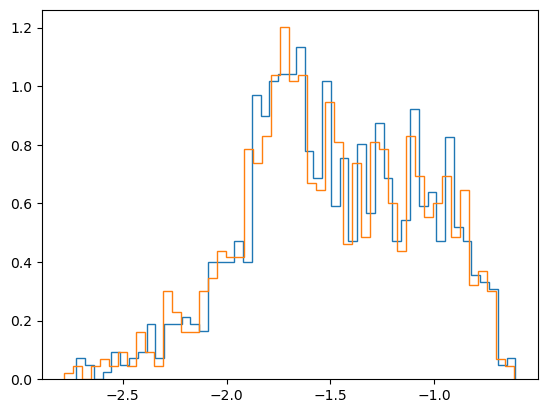

In [15]:
approx_PhenomD = lalsim.GetApproximantFromString("IMRPhenomD")
extra_params = lal.CreateDict()

def _minimized_mismatch_NRhyb_PhenomD(mass_1, mass_2, chi_1, chi_2):
    _, _, _, hf_hyb, freq = fd_waveform_NRHybSur3dq8(mass_1, mass_2, chi_1, chi_2)
    freq_mask = (freq >= minimum_frequency) * (freq <= maximum_frequency)
    freq = freq[freq_mask]
    hf_hyb = hf_hyb[freq_mask]
    delta_f = freq[1] - freq[0]

    hf_d = fd_waveform_approx(
        approx_PhenomD, extra_params, freq, mass_1, mass_2, chi_1, chi_2
    )

    psd_array = PSD_Aplus.get_power_spectral_density_array(freq)

    minimizing_res = scipy.optimize.dual_annealing(
        _mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(freq, delta_f, psd_array, hf_hyb, hf_d),
    )
    if minimizing_res.success:
        return minimizing_res.fun
    else:
        raise ValueError("minimizing func exited fail")


nproc = 72
with Pool(processes=nproc) as pool:
    mism = np.array(pool.starmap(_minimized_mismatch_NRhyb_PhenomD, params_array))
parameters["mismatch_NRhyb_PhenomD"] = mism
print(parameters)


param_keys = list(parameters.keys())
structed_params = np.array(
    list(zip(*[parameters[key] for key in param_keys])),
    dtype=[(key, "float") for key in param_keys],
)
np.save("mismatch_hyb_d", structed_params)
print(structed_params)

fig, ax = plt.subplots()
ax.hist(
    np.log10(parameters["mismatch_NRhyb_PhenomD"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_d",
)
ax.hist(
    np.log10(parameters["mismatch"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_xas",
)
fig.show()

{'total_mass': array([168.04610843,  91.95619094, 188.6221055 ,  24.27839885,
       192.48775514, 249.98228619, 205.78982711,  29.11158424,
       102.62270476,  38.86825463,  77.3556134 , 238.61323666,
       223.37252163,  31.70307647, 156.20493992,  35.66889654,
       109.87469305,  27.17272613,  40.75213717,  25.22908275,
       176.9312929 ,  38.97023297,  52.4493925 ,  27.59912898,
       190.811042  , 220.75864704, 197.50407433,  99.14773134,
        95.335524  ,  23.22894239,  50.52681129,  40.77040634,
        27.3705035 , 201.11009835, 196.98841494, 110.96674701,
       215.64257625, 247.46629213, 243.13099624, 111.7601093 ,
       158.23873468,  97.60522195,  87.24554923,  52.12611687,
       140.38636428, 163.86926132, 201.83078424, 179.07137348,
       235.33850825, 151.89478724,  39.04481685,  47.29617316,
        55.48193946, 176.19740471, 203.3711215 , 234.11705193,
       164.5187397 ,  89.15260491,  69.35262685, 184.07233671,
       133.03548846, 140.57031247,  86.4

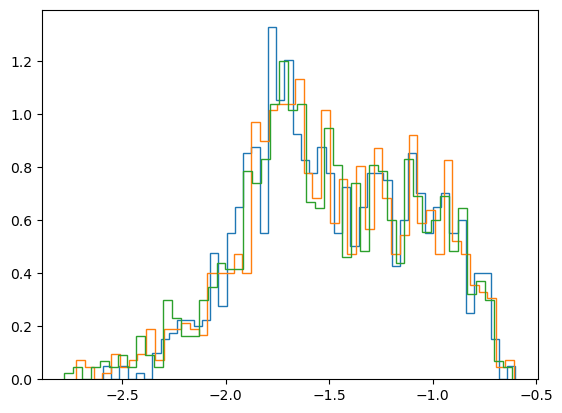

In [16]:
approx_SEOB = lalsim.GetApproximantFromString("SEOBNRv4_ROM")
extra_params = lal.CreateDict()

def _minimized_mismatch_NRhyb_SEOB(mass_1, mass_2, chi_1, chi_2):
    _, _, _, hf_hyb, freq = fd_waveform_NRHybSur3dq8(mass_1, mass_2, chi_1, chi_2)
    freq_mask = (freq >= minimum_frequency) * (freq <= maximum_frequency)
    freq = freq[freq_mask]
    hf_hyb = hf_hyb[freq_mask]
    delta_f = freq[1] - freq[0]

    hf_SEOB = fd_waveform_approx(
        approx_SEOB, extra_params, freq, mass_1, mass_2, chi_1, chi_2
    )

    psd_array = PSD_Aplus.get_power_spectral_density_array(freq)

    minimizing_res = scipy.optimize.dual_annealing(
        _mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(freq, delta_f, psd_array, hf_hyb, hf_SEOB),
    )
    if minimizing_res.success:
        return minimizing_res.fun
    else:
        raise ValueError("minimizing func exited fail")


nproc = 72
with Pool(processes=nproc) as pool:
    mism = np.array(pool.starmap(_minimized_mismatch_NRhyb_SEOB, params_array))
parameters["mismatch_NRhyb_SEOB"] = mism
print(parameters)


param_keys = list(parameters.keys())
structed_params = np.array(
    list(zip(*[parameters[key] for key in param_keys])),
    dtype=[(key, "float") for key in param_keys],
)
np.save("mismatch_hyb_SEOB", structed_params)
print(structed_params)

fig, ax = plt.subplots()
ax.hist(
    np.log10(parameters["mismatch_NRhyb_SEOB"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_SEOB",
)
ax.hist(
    np.log10(parameters["mismatch_NRhyb_PhenomD"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_d",
)
ax.hist(
    np.log10(parameters["mismatch"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_xas",
)
fig.show()

In [ ]:
duration = 16
full_length = duration * sampling_frequency
freq = np.fft.rfftfreq(full_length, 1 / sampling_frequency)
freq_mask = (freq >= minimum_frequency) * (freq <= maximum_frequency)
freq = freq[freq_mask]
delta_f = freq[1] - freq[0]


def _minimized_mismatch_PhenomD_SEOB(mass_1, mass_2, chi_1, chi_2):
    hf_PhenomD = fd_waveform_approx(
        approx_PhenomD, extra_params, freq, mass_1, mass_2, chi_1, chi_2
    )

    hf_SEOB = fd_waveform_approx(
        approx_SEOB, extra_params, freq, mass_1, mass_2, chi_1, chi_2
    )

    psd_array = PSD_Aplus.get_power_spectral_density_array(freq)

    minimizing_res = scipy.optimize.dual_annealing(
        _mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(freq, delta_f, psd_array, hf_PhenomD, hf_SEOB),
    )
    if minimizing_res.success:
        return minimizing_res.fun
    else:
        raise ValueError("minimizing func exited fail")


nproc = 72
with Pool(processes=nproc) as pool:
    mism = np.array(pool.starmap(_minimized_mismatch_PhenomD_SEOB, params_array))
parameters["mismatch_PhenomD_SEOB"] = mism
print(parameters)


param_keys = list(parameters.keys())
structed_params = np.array(
    list(zip(*[parameters[key] for key in param_keys])),
    dtype=[(key, "float") for key in param_keys],
)
np.save("mismatch_PhenomD_SEOB", structed_params)
print(structed_params)

fig, ax = plt.subplots()

ax.hist(
    np.log10(parameters["mismatch_PhenomD_SEOB"]),
    density=True,
    bins=50,
    histtype="step",
    label="PhenomD_SEOB",
)

ax.hist(
    np.log10(parameters["mismatch_NRhyb_SEOB"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_SEOB",
)
ax.hist(
    np.log10(parameters["mismatch_NRhyb_PhenomD"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_d",
)
ax.hist(
    np.log10(parameters["mismatch"]),
    density=True,
    bins=50,
    histtype="step",
    label="nrhyb_xas",
)
fig.show()